In [34]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import numpy as np
from qiskit_ionq import IonQProvider
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

import os
from getpass import getpass

from IPython.display import display

from fractions import Fraction
import math

In [11]:
def c_mult_2_mod_21(qc, control, w):
    qc.cx(control, w[1])
    qc.cx(control, w[2])

def c_mult_4_mod_21(qc, control, w):
    qc.cx(control, w[2])
    qc.cx(control, w[3])

def c_mult_16_mod_21(qc, control, w):
    qc.cx(control, w[0])
    qc.cx(control, w[4])

In [12]:
def iqft(qc, q):
    qc.h(q[2])
    qc.cp(-np.pi/2, q[1], q[2])
    qc.h(q[1])
    qc.cp(-np.pi/4, q[0], q[2])
    qc.cp(-np.pi/2, q[0], q[1])
    qc.h(q[0])

In [13]:
phase = QuantumRegister(3, 'phase')
work  = QuantumRegister(5, 'work')
c = ClassicalRegister(3, 'c')

qc = QuantumCircuit(phase, work, c)

# |1> in work register
qc.x(work[0])

# Hadamards
qc.h(phase)

c_mult_2_mod_21(qc, phase[0], work)
c_mult_4_mod_21(qc, phase[1], work)
c_mult_16_mod_21(qc, phase[2], work)

iqft(qc, phase)

qc.measure(phase, c)



In [38]:
def find_order(measured_value, t, a, N, max_den=50):
    """
    measured_value: integer measurement outcome
    t: number of phase qubits
    """
    frac = Fraction(measured_value, 2**t).limit_denominator(max_den)
    r = frac.denominator

    # Verify order
    if pow(a, r, N) == 1:
        return r
    return None

In [44]:
def find_order_from_measurement(m, t, a, N, max_den=20, max_mult=6):
    frac = Fraction(m, 2**t).limit_denominator(max_den)
    d = frac.denominator

    for k in range(1, max_mult + 1):
        r = k * d
        if pow(a, r, N) == 1:
            return r
    return None

def get_candidate_rs(counts, t, a, N, top_k=6):
    candidates = sorted(counts.items(), key=lambda x: -x[1])[:top_k]
    rs = set()

    for bitstring, _ in candidates:
        m = int(bitstring, 2)
        r = find_order_from_measurement(m, t, a, N)
        if r:
            rs.add(r)

    return rs

In [45]:
def shor_factors_from_r(r, a, N):
    if r % 2 != 0:
        return None

    x = pow(a, r // 2, N)

    if x == N - 1 or x == 1:
        return None

    f1 = math.gcd(x - 1, N)
    f2 = math.gcd(x + 1, N)

    if f1 * f2 == N:
        return f1, f2

    return None

In [31]:
api_key = os.getenv('IONQ_API_KEY') or getpass("IonQ API key: ")
provider = IonQProvider(api_key)

backend = provider.get_backend("ionq_simulator")

tqc = transpile(
    qc,
    backend=backend,
    optimization_level=3
)

job = backend.run([tqc], shots=2000)
result = job.result()

/home/killian/IonQ/qiskit_project/qiskit-env/lib/python3.12/site-packages/qiskit_ionq/ionq_backend.py:127: IonQTranspileLevelWarning: Transpiler default optimization_level=2. IonQ (QIS) recommends 0-1 to avoid aggressive re-synthesis; use transpile(..., optimization_level=1).
  warn_bad_transpile_level()


{'000': 244, '001': 242, '010': 250, '011': 265, '100': 235, '101': 248, '110': 249, '111': 267}


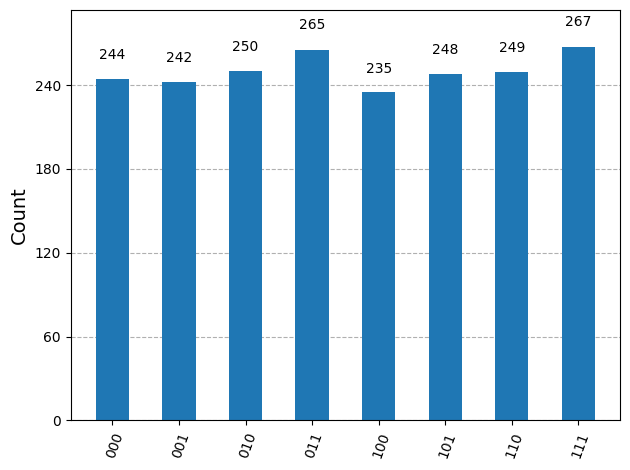

In [42]:
counts = result.get_counts()

print(counts)

fig = plot_histogram(counts)
display(fig)

In [47]:
N = 21
a = 2
t = 3   # number of phase qubits

rs = get_candidate_rs(counts, t, a, N)

print("Candidate r values:", rs)

for r in rs:
    factors = shor_factors_from_r(r, a, N)
    if factors:
        print(f"SUCCESS: r = {r}, factors = {factors}")

Candidate r values: {24, 12, 6}
SUCCESS: r = 6, factors = (7, 3)
